<h1 align='center'>Welcome to the Human Protein Atlas - Single Cell Classification Competition!</h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/23823/logos/header.png)

<a id="top" href="#a"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:#112; background:#e685e2; border:0' role="tab" aria-controls="home"><center>Quick Navigation</center></h3>

* [0. Brief about single cell type atlas](#0)
    
* [1. Feature Engineering](#1)
    
* [2. EDA](#2)
    
* [3. Image Segmentation](#3)

<a id="0"></a>
<h2 style='background:#e685e2; border:0; color:#112' align='center'>Brief about Single Cell Type Atlas</h2>

> The **Single Cell Type Atlas** contains single cell **RNA sequencing (scRNAseq)** data from 13 different human tissues, together with in-house generated immunohistochemically stained tissue sections visualizing the corresponding spatial protein expression patterns. The scRNAseq analysis was based on publicly available genome-wide expression data and comprises all protein-coding genes in 192 individual cell type clusters corresponding to 12 different cell type groups. A specificity and distribution classification was performed to determine the number of genes elevated in these single cell types, and the number of genes detected in one, several or all cell types, respectively.



<h1><center>Importing dependencies</center></h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from collections import Counter

import os
print(os.listdir("../input/hpa-single-cell-image-classification"))

['train_tfrecords', 'sample_submission.csv', 'test_tfrecords', 'train.csv', 'test', 'train']


In [2]:
train_df = pd.read_csv("../input/hpa-single-cell-image-classification/train.csv")
train_df.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


<a id="1"></a>
<h2 style='background:#e685e2; border:0; color:#112' align='center'>Feature Engineering</h2>

Mapping of targets in a location:
---

In [3]:

label_names= {
0: "Nucleoplasm",
1: "Nuclear membrane",
2: "Nucleoli",
3: "Nucleoli fibrillar center",
4: "Nuclear speckles",
5: "Nuclear bodies",
6: "Endoplasmic reticulum",
7: "Golgi apparatus",
8: "Intermediate filaments",
9: "Actin filaments",
10: "Microtubules",
11: "Mitotic spindle",
12: "Centrosome",
13: "Plasma membrane",
14: "Mitochondria",
15: "Aggresome",
16: "Cytosol",
17: "Vesicles and punctate cytosolic patterns",
18: "Negative"
}
reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Label.replace("|", " ").split()).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row


---
**Each sample consists of four image files. Each file represents a different filter on the subcellular protein patterns represented by the sample (ID).**

> **Red for Microtubule channels.**

> **Blue for Nuclei channels.**

> **Yellow for Endoplasmic Reticulum (ER) channels.**

> **Green for Protein of interest.**

---

The image with ID == 0 has the following labels: 8|5|0
These labels correspond to:
- Intermediate filaments
- Nuclear bodies
- Nucleoplasm


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibD

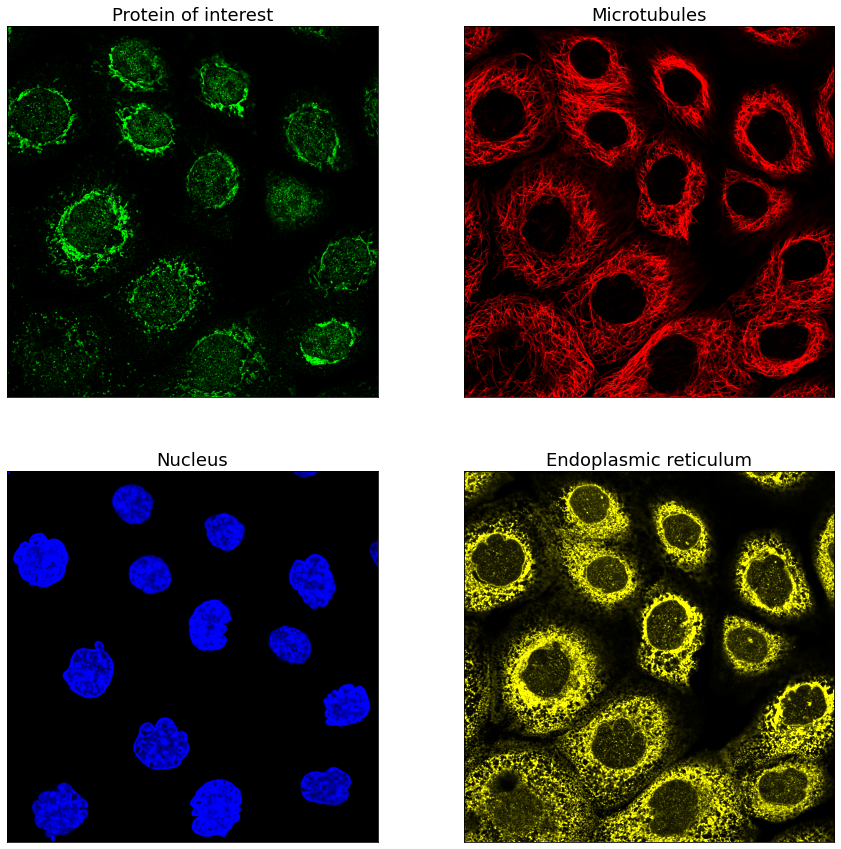

In [4]:
print("The image with ID == 0 has the following labels:", train_df.loc[0, "Label"])
print("These labels correspond to:")
for location in train_df.loc[0, "Label"].replace("|", " ").split():
    print("-", label_names[int(location)])

#reset seaborn style
sns.reset_orig()

#get image id
im_id = train_df.loc[1, "ID"]


cdict1 = {'red':   ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)),

         'green': ((0.0,  0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)),

         'blue':  ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0))}

cdict2 = {'red':   ((0.0,  0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)),

         'green': ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)),

         'blue':  ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0))}

cdict3 = {'red':   ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)),

         'green': ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)),

         'blue':  ((0.0,  0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0))}

cdict4 = {'red': ((0.0,  0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)),

         'green': ((0.0,  0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)),

         'blue':  ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0))}

plt.register_cmap(name='greens', data=cdict1)
plt.register_cmap(name='reds', data=cdict2)
plt.register_cmap(name='blues', data=cdict3)
plt.register_cmap(name='yellows', data=cdict4)

#get each image channel as a greyscale image (second argument 0 in imread)
green = cv2.imread('../input/hpa-single-cell-image-classification/train/{}_green.png'.format(im_id), 0)
red = cv2.imread('../input/hpa-single-cell-image-classification/train/{}_red.png'.format(im_id), 0)
blue = cv2.imread('../input/hpa-single-cell-image-classification/train/{}_blue.png'.format(im_id), 0)
yellow = cv2.imread('../input/hpa-single-cell-image-classification/train/{}_yellow.png'.format(im_id), 0)

#display each channel separately
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(15, 15))
ax[0, 0].imshow(green, cmap="greens")
ax[0, 0].set_title("Protein of interest", fontsize=18)
ax[0, 1].imshow(red, cmap="reds")
ax[0, 1].set_title("Microtubules", fontsize=18)
ax[1, 0].imshow(blue, cmap="blues")
ax[1, 0].set_title("Nucleus", fontsize=18)
ax[1, 1].imshow(yellow, cmap="yellows")
ax[1, 1].set_title("Endoplasmic reticulum", fontsize=18)
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].tick_params(left=False, bottom=False)
plt.show()

In [5]:
for key in label_names.keys():
    train_df[label_names[key]] = 0

In [6]:
train_df = train_df.apply(fill_targets, axis=1)
train_df.head()

,ID,Label,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Actin filaments,Microtubules,Mitotic spindle,Centrosome,Plasma membrane,Mitochondria,Aggresome,Cytosol,Vesicles and punctate cytosolic patterns,Negative
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


<a id="2"></a>
<h2 style='background:#e685e2; border:0; color:#112' align='center'>EDA</h2>

<AxesSubplot:>

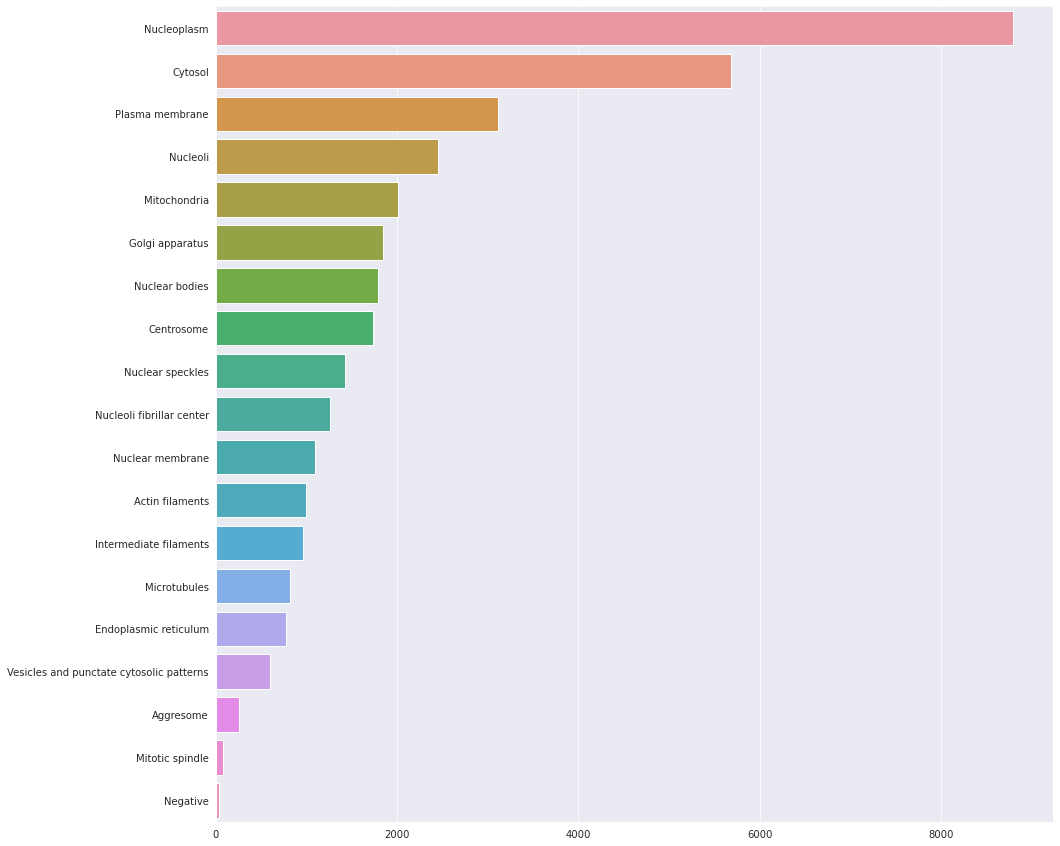

In [7]:
target_counts = train_df.drop(["ID", "Label"],axis=1).sum(axis=0).sort_values(ascending=False)
sns.set_style("darkgrid")
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

Take away:
---
> **We can see that most common protein structures belong to coarse grained cellular components like the plasma membrane, the cytosol and the nucleus.**

Text(0, 0.5, '% of train data')

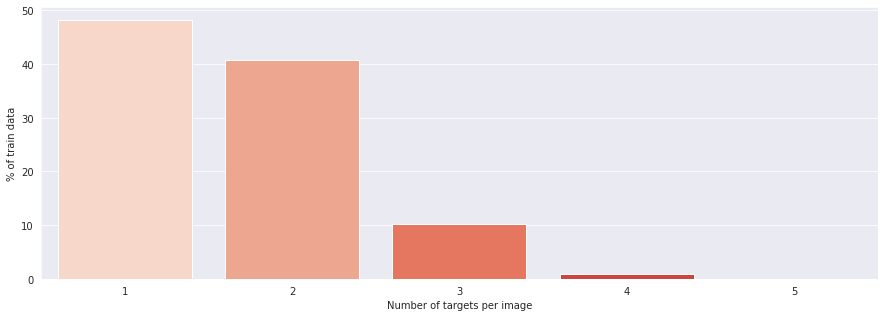

In [8]:
train_df["number_of_targets"] = train_df.drop(["ID","Label"],axis=1).sum(axis=1)
count_perc = np.round(100 * train_df["number_of_targets"].value_counts() / train_df.shape[0], 2)
plt.figure(figsize=(15,5))
sns.set_style("darkgrid")
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Reds")
plt.xlabel("Number of targets per image")
plt.ylabel("% of train data")

Take away:
---
> **Most train images only have 1 or two target labels.**

> **More than 3 targets are sporadic!**

<AxesSubplot:>

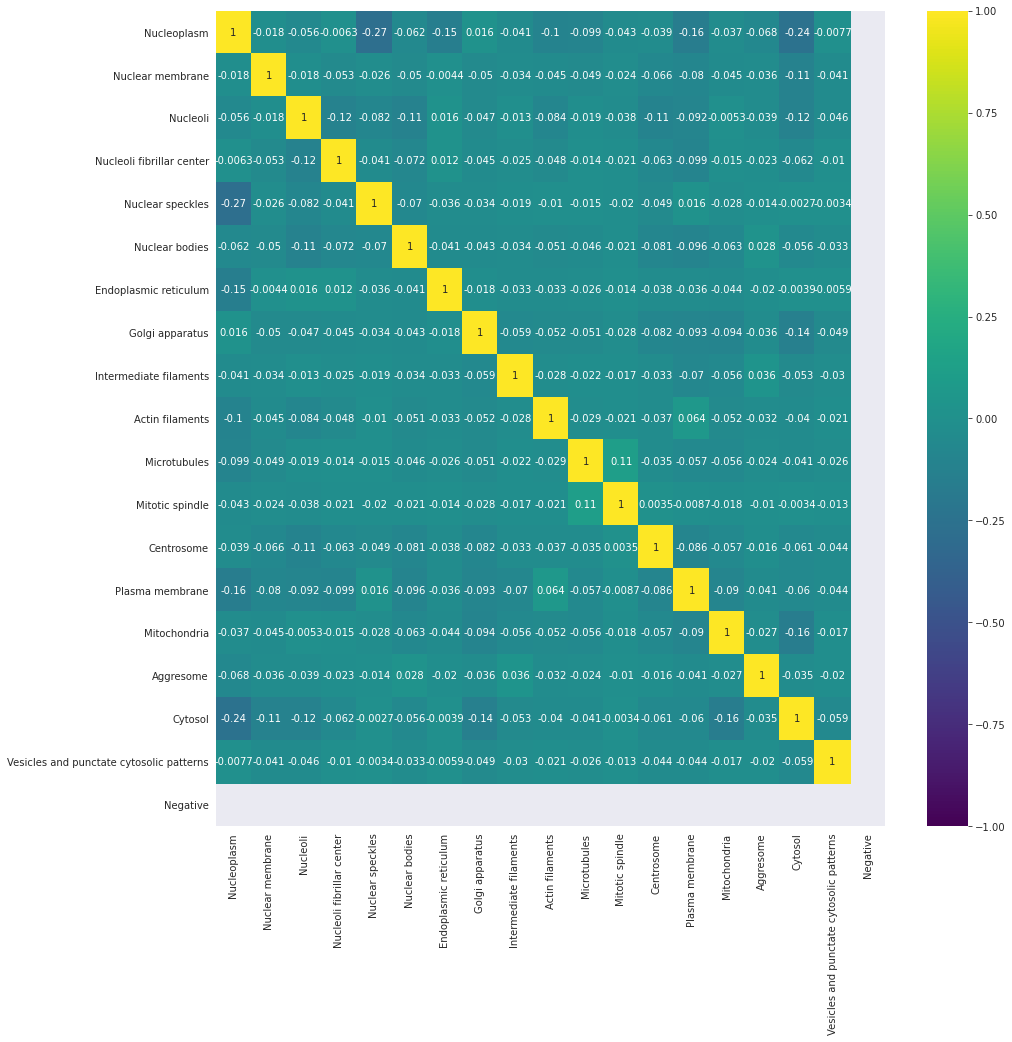

In [9]:
plt.figure(figsize=(15,15))

sns.heatmap(train_df[train_df.number_of_targets>1].drop(["ID", "Label", "number_of_targets"],axis=1).corr(), annot=True,cmap="viridis", vmin=-1, vmax=1)

Take away:
---

> We can see that many targets only have ***very slight*** correlations.

>In addition we find that the **Mitotic spindle** often comes together with the **Microtubules**. This makes sense as both are participants for cellular division. And in this process microtubules and thier ends are active and participate as well. Consequently we find a positive correlation between these targets.


<a id="3"></a>
<h2 style='background:#e685e2; border:0; color:#112' align='center'>Image Segmentation</h2>

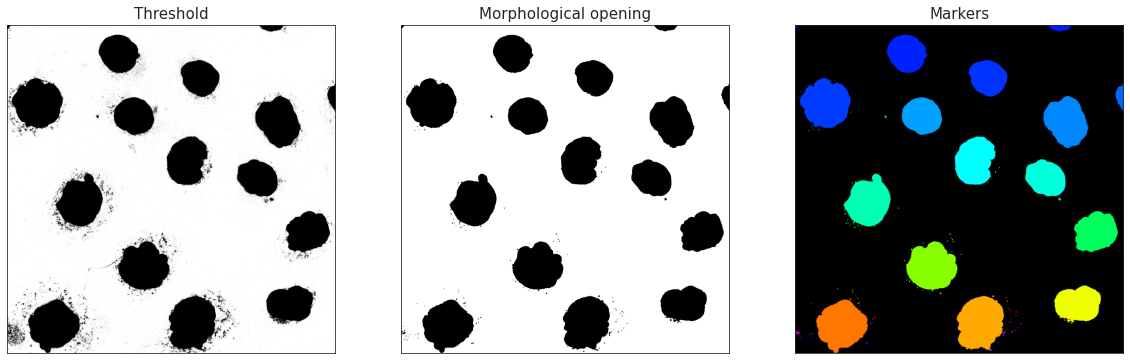

In [10]:
#apply threshold on the nucleus image
sns.set_style("white")
ret, thresh = cv2.threshold(blue, 0, 255, cv2.THRESH_BINARY)
#display threshold image
fig, ax = plt.subplots(ncols=3, figsize=(20, 20))
ax[0].imshow(thresh, cmap="Greys")
ax[0].set_title("Threshold", fontsize=15)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].tick_params(left=False, bottom=False)

#morphological opening to remove noise
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
ax[1].imshow(opening, cmap="Greys")
ax[1].set_title("Morphological opening", fontsize=15)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].tick_params(left=False, bottom=False)

# Marker labelling
ret, markers = cv2.connectedComponents(opening)
# Map component labels to hue val
label_hue = np.uint8(179 * markers / np.max(markers))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
# cvt to BGR for display
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
# set bg label to black
labeled_img[label_hue==0] = 0
ax[2].imshow(labeled_img)
ax[2].set_title("Markers", fontsize=15)
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].tick_params(left=False, bottom=False)


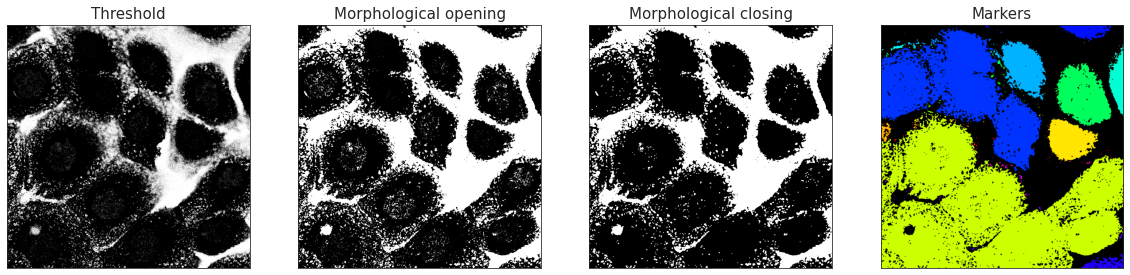

In [11]:
#apply threshold on the endoplasmic reticulum image
sns.set_style("white")
ret, thresh = cv2.threshold(yellow, 4, 255, cv2.THRESH_BINARY)
#display threshold image
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
ax[0].imshow(thresh, cmap="Greys")
ax[0].set_title("Threshold", fontsize=15)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].tick_params(left=False, bottom=False)

#morphological opening to remove noise
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
ax[1].imshow(opening, cmap="Greys")
ax[1].set_title("Morphological opening", fontsize=15)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].tick_params(left=False, bottom=False)

#morphological closing
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
ax[2].imshow(closing, cmap="Greys")
ax[2].set_title("Morphological closing", fontsize=15)
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].tick_params(left=False, bottom=False)

# Marker labelling
ret, markers = cv2.connectedComponents(closing)
# Map component labels to hue val
label_hue = np.uint8(179 * markers / np.max(markers))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
# cvt to BGR for display
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
# set bg label to black
labeled_img[label_hue==0] = 0
ax[3].imshow(labeled_img)
ax[3].set_title("Markers", fontsize=15)
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])
ax[3].tick_params(left=False, bottom=False)

Text(0.5, 1.0, 'To zero')

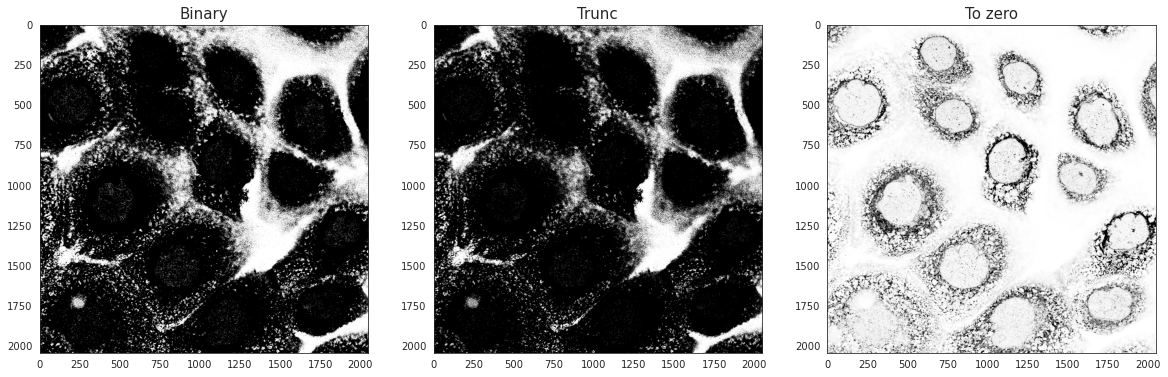

In [12]:
#apply threshold on the endoplasmic reticulum image
ret, thresh1 = cv2.threshold(yellow, 4, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(yellow, 4, 255, cv2.THRESH_TRUNC)
ret, thresh3 = cv2.threshold(yellow, 4, 255, cv2.THRESH_TOZERO)

#display threshold images
sns.set_style("white")
fig, ax = plt.subplots(ncols=3, figsize=(20, 20))
ax[0].imshow(thresh1, cmap="Greys")
ax[0].set_title("Binary", fontsize=15)

ax[1].imshow(thresh2, cmap="Greys")
ax[1].set_title("Trunc", fontsize=15)

ax[2].imshow(thresh3, cmap="Greys")
ax[2].set_title("To zero", fontsize=15)

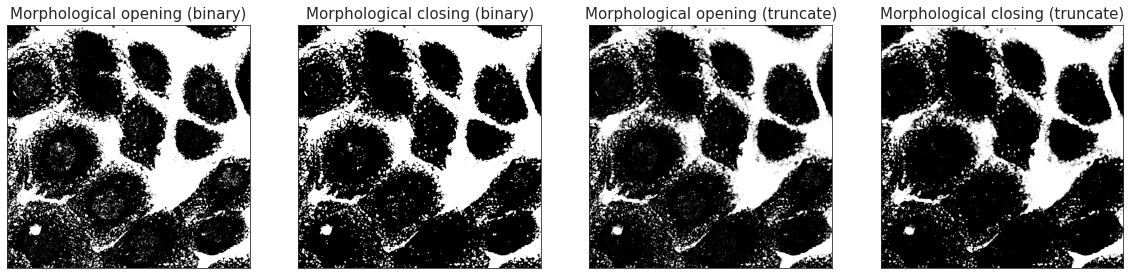

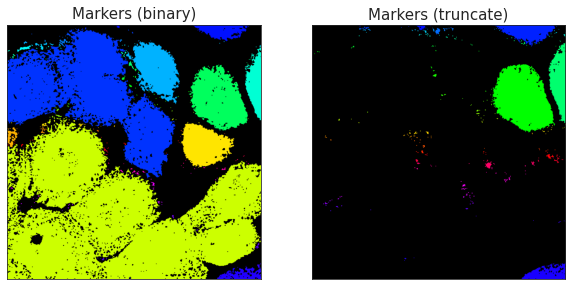

In [13]:
sns.set_style("white")
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

#morphological opening to remove noise after binary thresholding
kernel = np.ones((5,5),np.uint8)
opening1 = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
ax[0].imshow(opening1, cmap="Greys")
ax[0].set_title("Morphological opening (binary)", fontsize=15)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].tick_params(left=False, bottom=False)

#morphological closing after binary thresholding
closing1 = cv2.morphologyEx(opening1, cv2.MORPH_CLOSE, kernel)
ax[1].imshow(closing1, cmap="Greys")
ax[1].set_title("Morphological closing (binary)", fontsize=15)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].tick_params(left=False, bottom=False)

#morphological opening to remove noise after truncate thresholding
kernel = np.ones((5,5),np.uint8)
opening2 = cv2.morphologyEx(thresh2, cv2.MORPH_OPEN, kernel)
ax[2].imshow(opening2, cmap="Greys")
ax[2].set_title("Morphological opening (truncate)", fontsize=15)
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].tick_params(left=False, bottom=False)

#morphological closing after truncate thresholding
closing2 = cv2.morphologyEx(opening2, cv2.MORPH_CLOSE, kernel)
ax[3].imshow(closing2, cmap="Greys")
ax[3].set_title("Morphological closing (truncate)", fontsize=15)
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])
ax[3].tick_params(left=False, bottom=False)

fig, ax = plt.subplots(ncols=2, figsize=(10, 10))
# Marker labelling for binary thresholding
ret, markers1 = cv2.connectedComponents(closing1)
# Map component labels to hue val
label_hue1 = np.uint8(179 * markers1 / np.max(markers1))
blank_ch1 = 255 * np.ones_like(label_hue1)
labeled_img1 = cv2.merge([label_hue1, blank_ch1, blank_ch1])
# cvt to BGR for display
labeled_img1 = cv2.cvtColor(labeled_img1, cv2.COLOR_HSV2BGR)
# set bg label to black
labeled_img1[label_hue1==0] = 0
ax[0].imshow(labeled_img1)
ax[0].set_title("Markers (binary)", fontsize=15)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].tick_params(left=False, bottom=False)

# Marker labelling for truncate thresholding
ret, markers2 = cv2.connectedComponents(closing2)
# Map component labels to hue val
label_hue2 = np.uint8(179 * markers2 / np.max(markers2))
blank_ch2 = 255 * np.ones_like(label_hue2)
labeled_img2 = cv2.merge([label_hue2, blank_ch2, blank_ch2])
# cvt to BGR for display
labeled_img2 = cv2.cvtColor(labeled_img2, cv2.COLOR_HSV2BGR)
# set bg label to black
labeled_img2[label_hue2==0] = 0
ax[1].imshow(labeled_img2)
ax[1].set_title("Markers (truncate)", fontsize=15)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].tick_params(left=False, bottom=False)


Text(0.5, 1.0, 'Adaptive: gaussian')

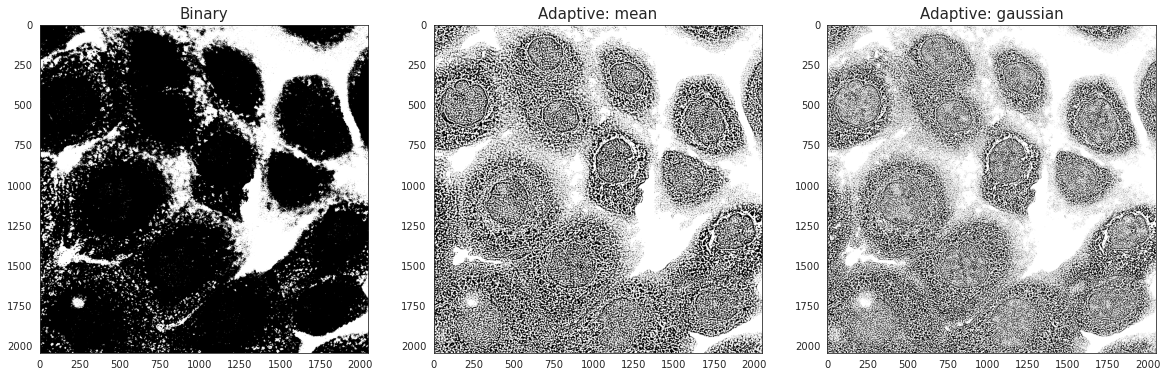

In [14]:
#apply adaptive threshold on endoplasmic reticulum image
y_blur = cv2.medianBlur(yellow, 3)

#apply adaptive thresholding
ret,th1 = cv2.threshold(y_blur, 5,255, cv2.THRESH_BINARY)

th2 = cv2.adaptiveThreshold(y_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 3)

th3 = cv2.adaptiveThreshold(y_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 3)

#display threshold images
sns.set_style("white")
fig, ax = plt.subplots(ncols=3, figsize=(20, 20))
ax[0].imshow(th1, cmap="Greys")
ax[0].set_title("Binary", fontsize=15)

ax[1].imshow(th2, cmap="Greys_r")
ax[1].set_title("Adaptive: mean", fontsize=15)

ax[2].imshow(th3, cmap="Greys_r")
ax[2].set_title("Adaptive: gaussian", fontsize=15)


Reference:
---
> https://www.kaggle.com/allunia/protein-atlas-exploration-and-baseline/

> https://docs.opencv.org/

<center><font color='Red' size='5'>Stay tuned for more Updates</font>